# Analyse von Hunderassen und ihren Gesundheitsproblemen

Dieses Notebook analysiert Daten über Hunderassen, um zu verstehen, welches Hauptmerkmal am stärksten mit häufigen Gesundheitsproblemen korreliert.

In [1]:
# Importieren der benötigten Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import re
import sqlite3
from kaggle.api.kaggle_api_extended import KaggleApi

In [2]:
# Kaggle-API-Konfiguration und Datenladen
api = KaggleApi()
api.authenticate()
api.dataset_download_files("marshuu/dog-breeds", unzip=True, path='../data')
df = pd.read_csv('../data/dog_breeds.csv')

In [3]:
## Datenbereinigung und Vorbereitung
# Umwandlung von 'Height (in)' und 'Longevity (yrs)' in numerische Werte mittels regulärer Ausdrücke
def extract_numeric_average(text):
    numbers = re.findall(r'\d+\.?\d*', text)
    numbers = [float(num) for num in numbers]
    return sum(numbers) / len(numbers) if numbers else None

df['Height (in)'] = df['Height (in)'].apply(extract_numeric_average)
df['Height (cm)'] = df['Height (in)'] * 2.54
df['Longevity (yrs)'] = df['Longevity (yrs)'].apply(extract_numeric_average)

# Erstellen von Dummy-Variablen für gesundheitliche Probleme
df['Common Health Problems'] = df['Common Health Problems'].str.lower()
health_problems_dummies = df['Common Health Problems'].str.get_dummies(sep=', ')
df = pd.concat([df, health_problems_dummies], axis=1)

# Gruppeneinteilung basierend auf der Größe
median_height = df['Height (cm)'].median()
df['Size Group'] = np.where(df['Height (cm)'] > median_height, 'Large', 'Small')


In [4]:
# Speichern der bereinigten Daten in einer SQLite-Datenbank
conn = sqlite3.connect('../data/dog_breeds.db')
try:
    df.to_sql('cleaned_data', conn, if_exists='replace', index=False)
finally:
    conn.close()

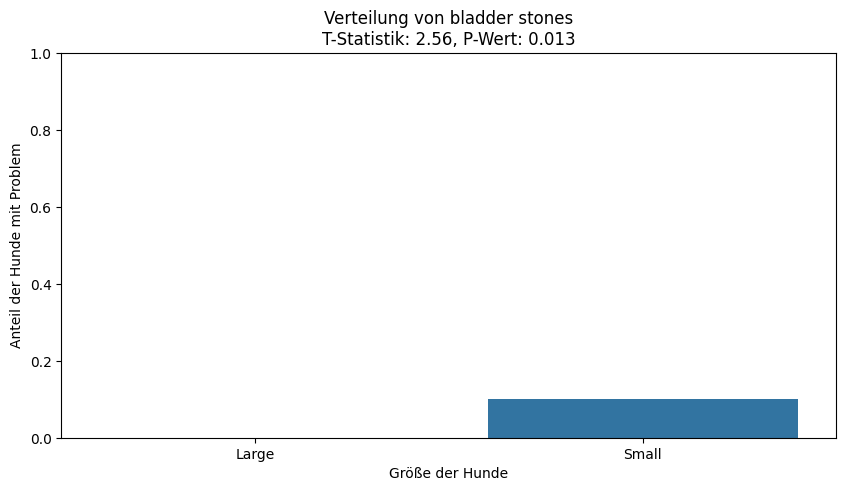

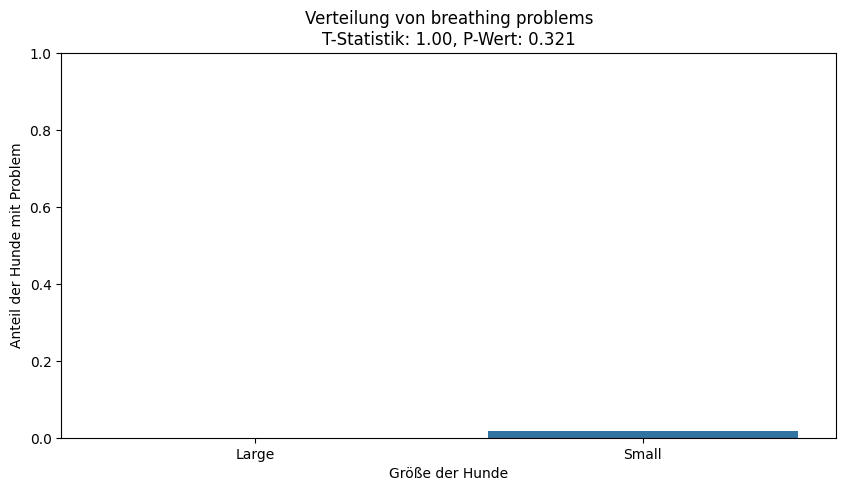

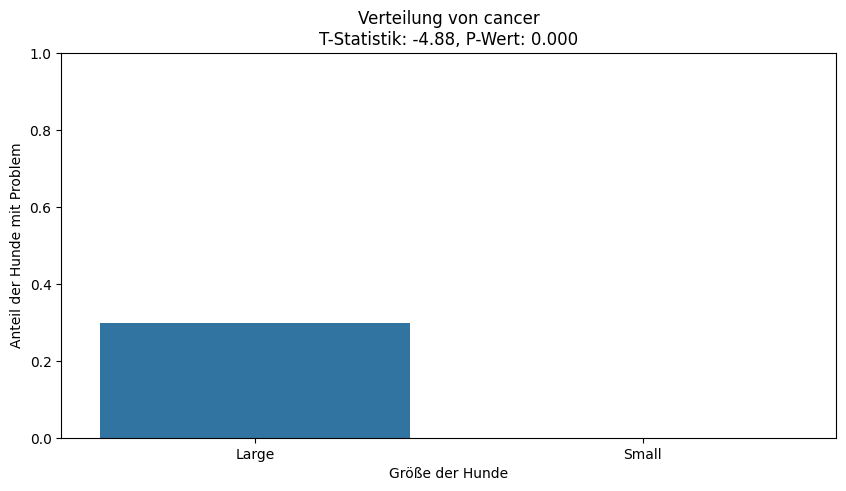

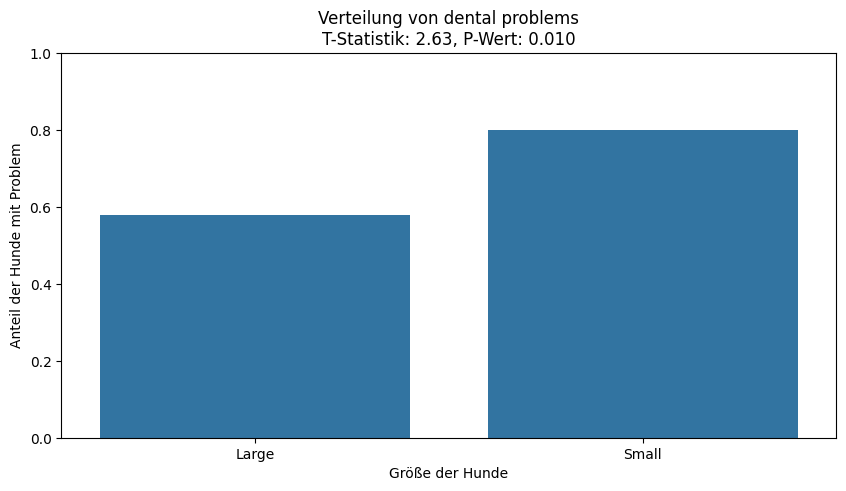

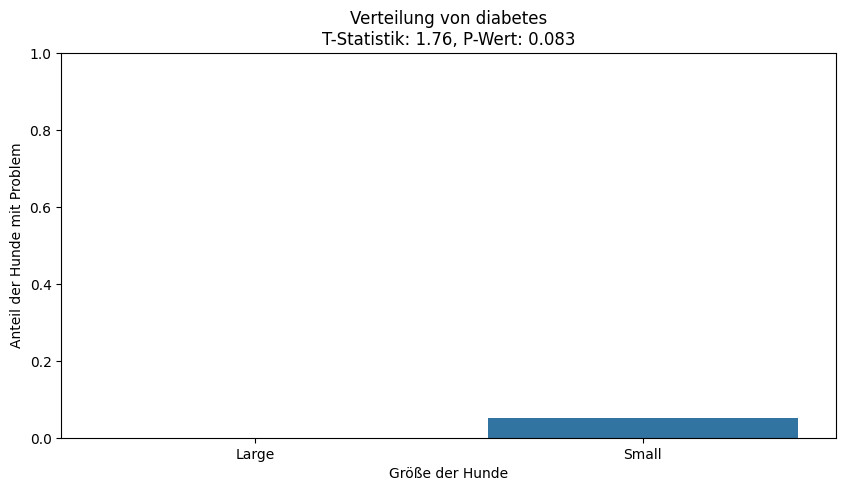

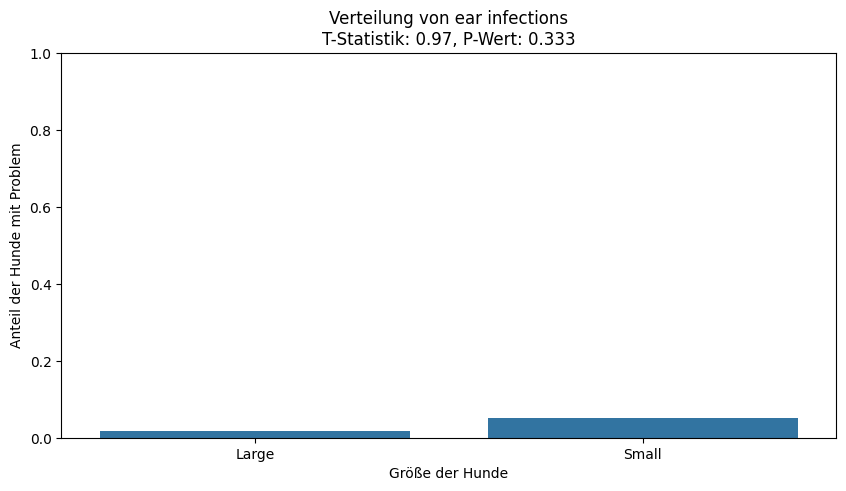

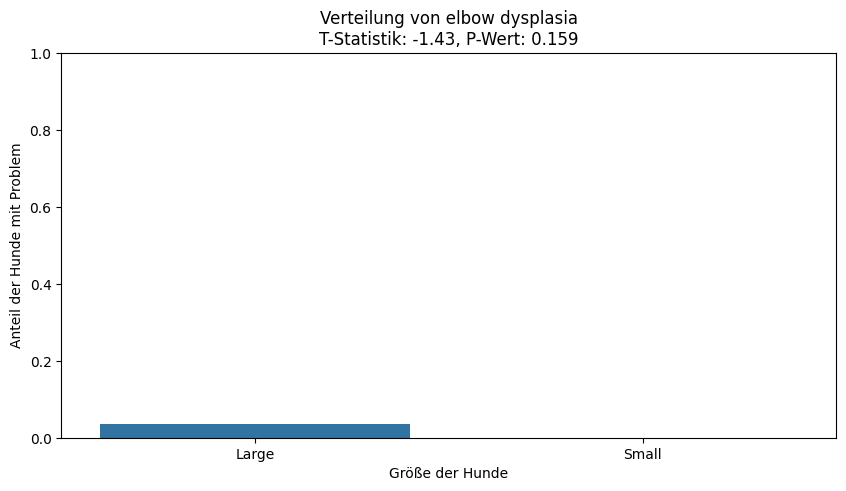

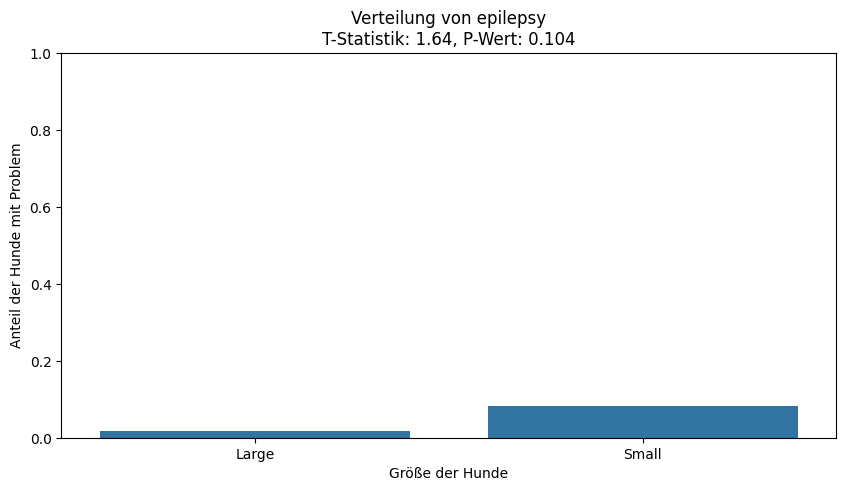

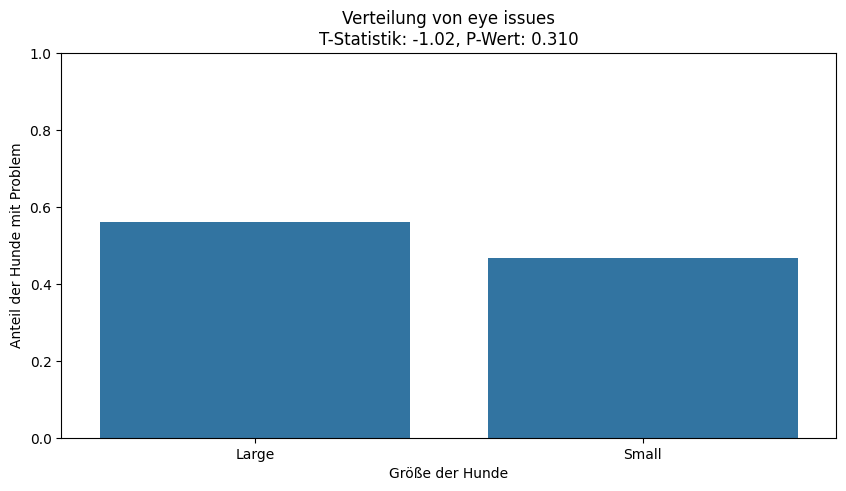

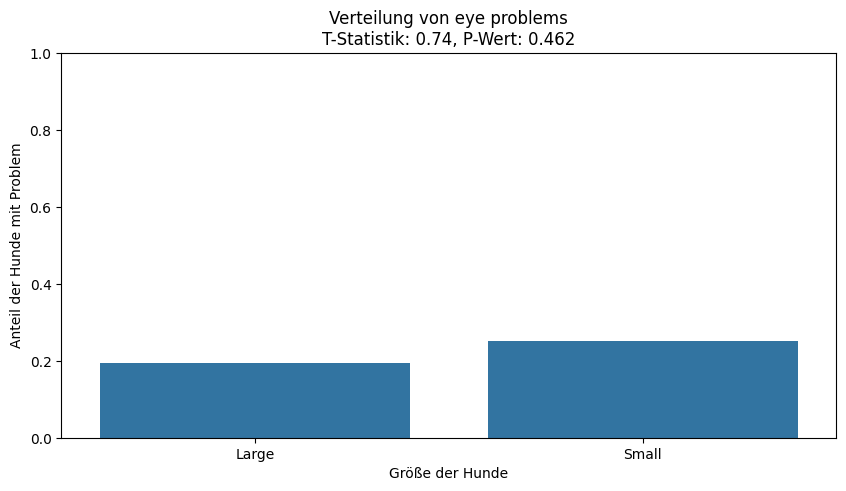

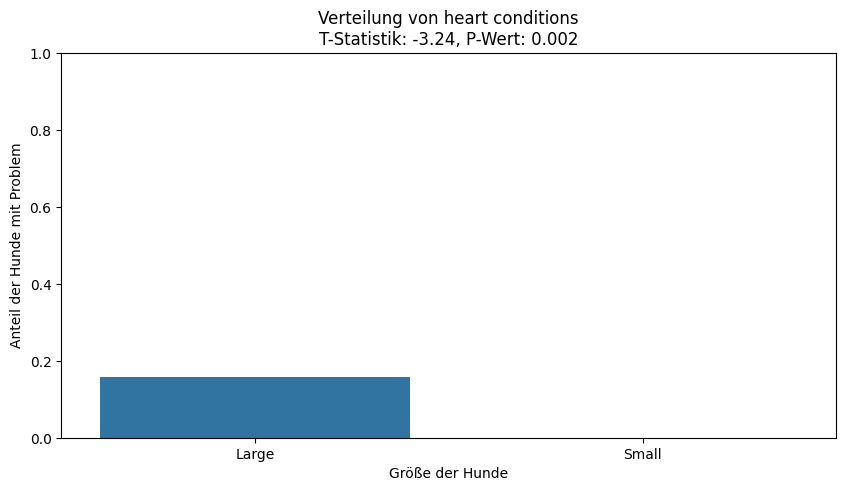

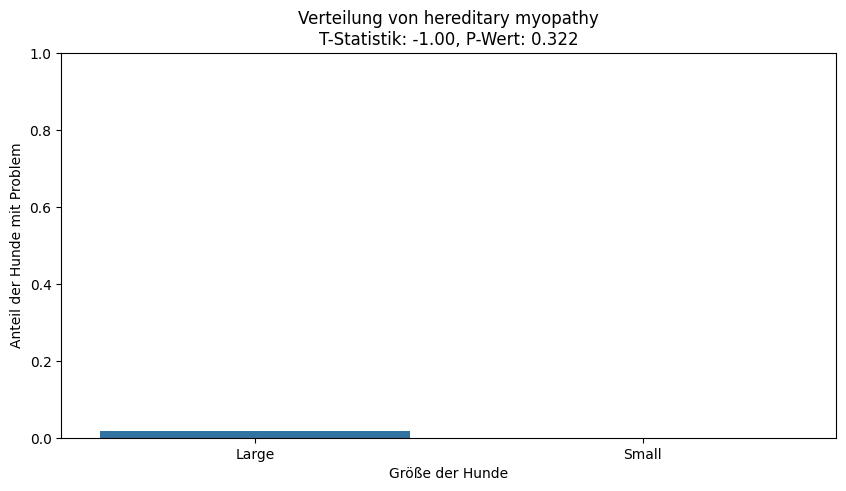

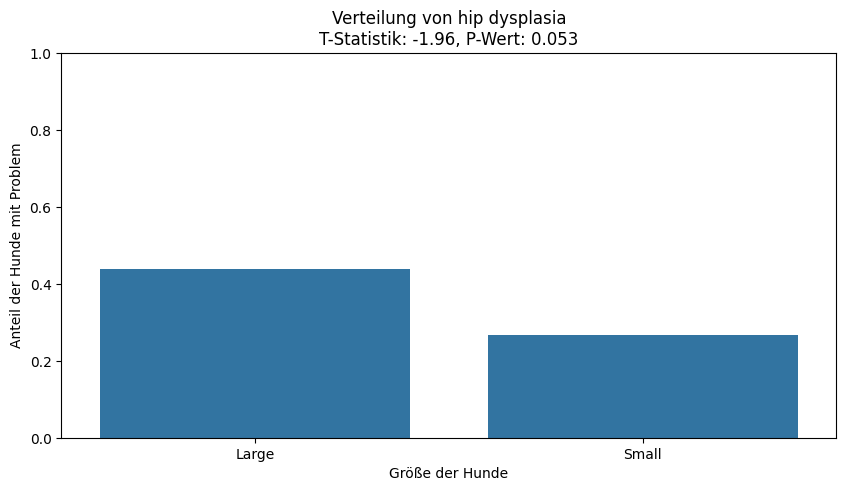

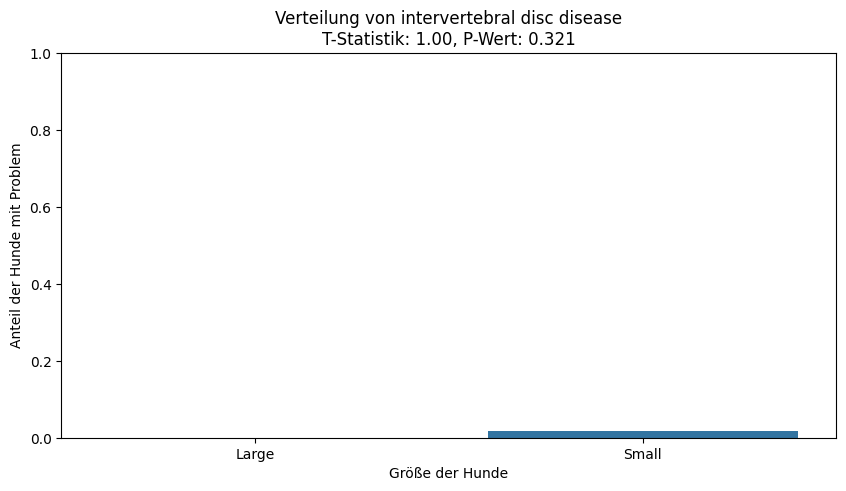

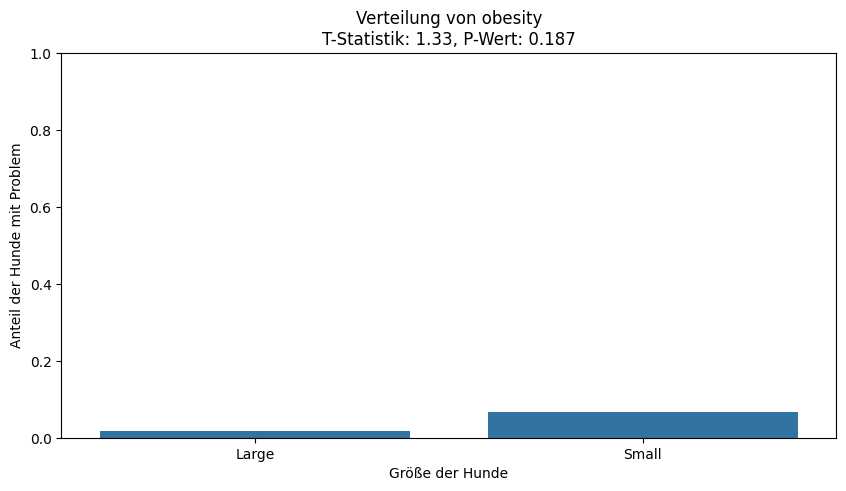

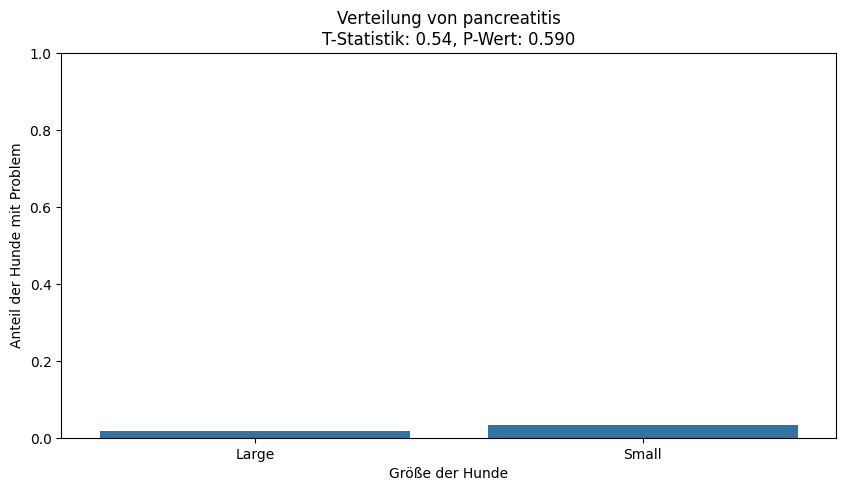

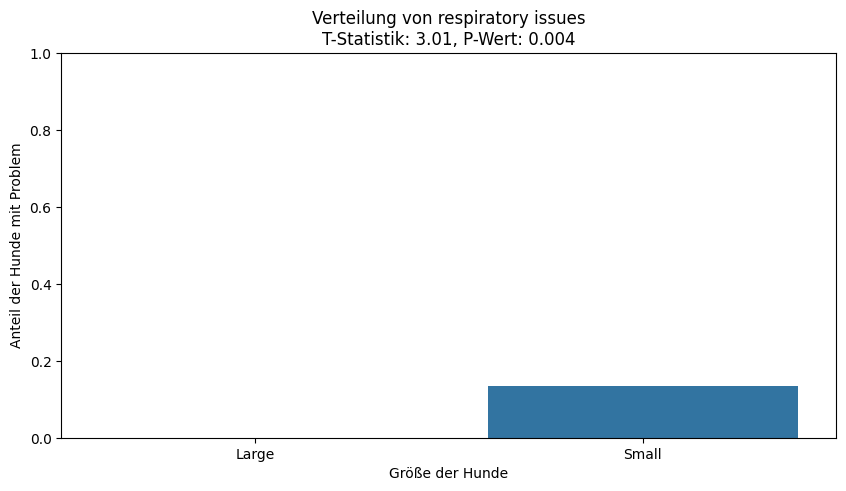

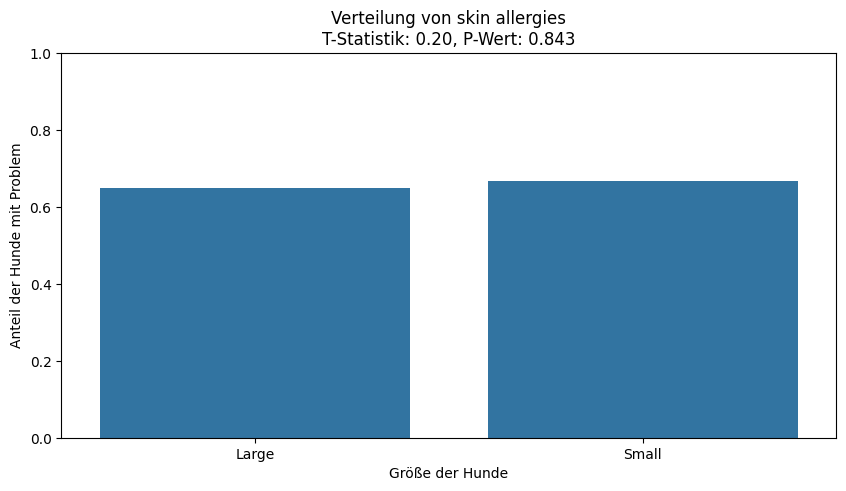

In [5]:
# Angenommen, Dummy-Variablen für Gesundheitsprobleme wurden erstellt
health_issues_columns = [col for col in health_problems_dummies.columns]

results = []
for issue in health_issues_columns:
    small_dogs = df[df['Size Group'] == 'Small'][issue]
    large_dogs = df[df['Size Group'] == 'Large'][issue]

    # Durchführen eines T-Tests
    t_stat, p_value = ttest_ind(small_dogs, large_dogs, equal_var=False)

    # Visualisierung der Ergebnisse
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Size Group', y=issue, data=df, estimator=np.mean, errorbar=None)
    plt.title(f'Verteilung von {issue}\nT-Statistik: {t_stat:.2f}, P-Wert: {p_value:.3f}')
    plt.ylabel('Anteil der Hunde mit Problem')
    plt.xlabel('Größe der Hunde')
    plt.ylim(0, 1)
    plt.show()


Korrelation zwischen Charaktereigenschaften und Lebensdauer (yrs):


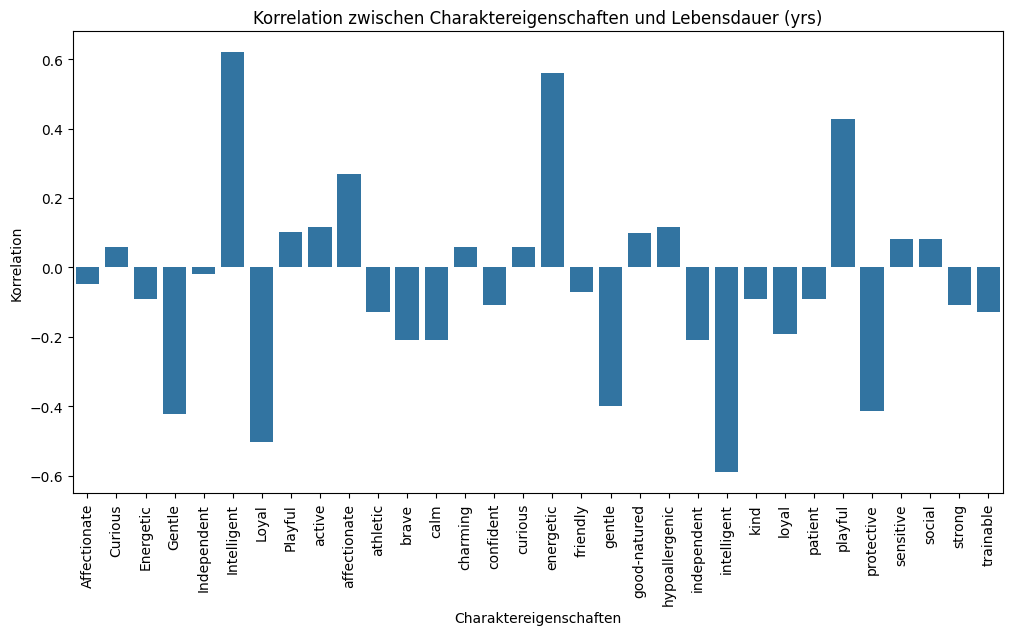

<Figure size 1500x1000 with 0 Axes>

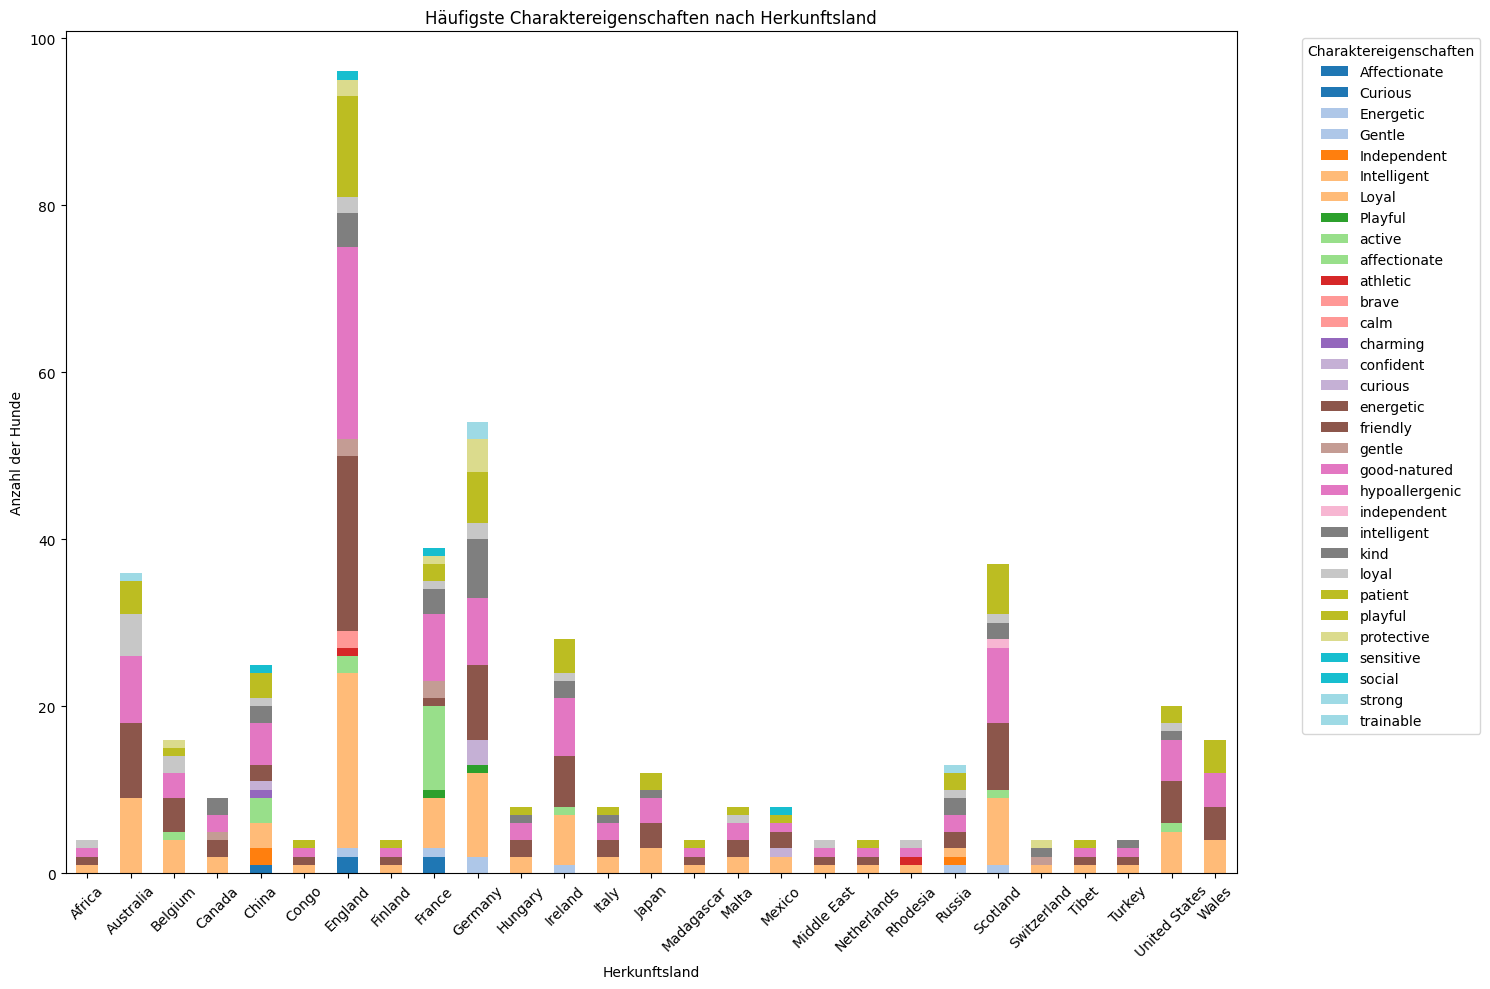

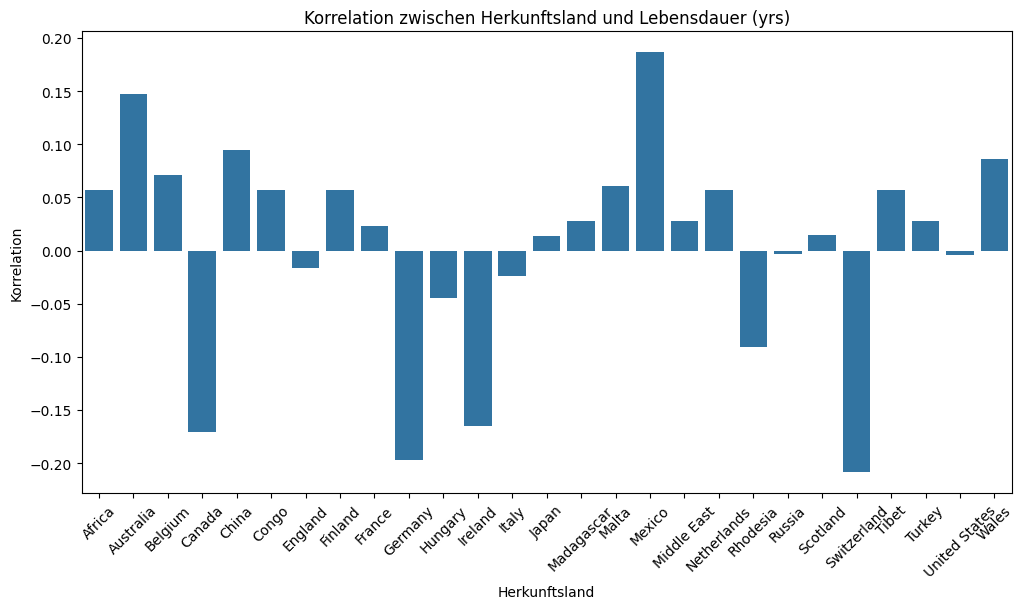

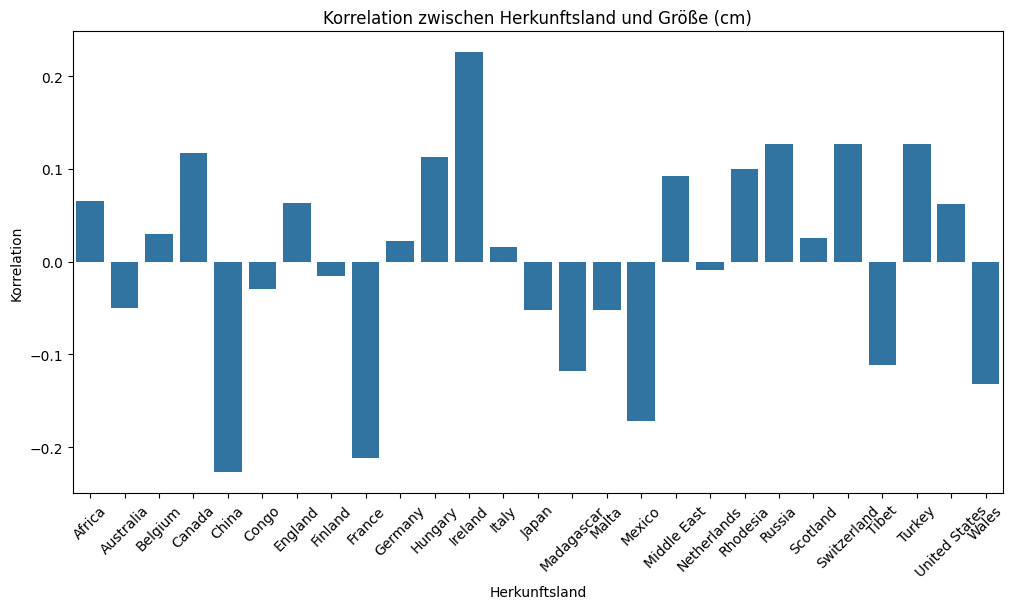

In [12]:
# Analyse der Korrelationen zwischen 'Character Traits' und 'Longevity (yrs)'
character_traits_dummies = df['Character Traits'].str.get_dummies(sep=', ')
correlation_character_longevity = character_traits_dummies.corrwith(df['Longevity (yrs)'])

# Ausgabe und Visualisierung der Korrelationen
print("\nKorrelation zwischen Charaktereigenschaften und Lebensdauer (yrs):")

plt.figure(figsize=(12, 6))
sns.barplot(x=correlation_character_longevity.index, y=correlation_character_longevity.values)
plt.xticks(rotation=90)
plt.title('Korrelation zwischen Charaktereigenschaften und Lebensdauer (yrs)')
plt.xlabel('Charaktereigenschaften')
plt.ylabel('Korrelation')
plt.show()

# Häufigste Charaktereigenschaften nach Herkunftsland
character_traits_dummies = df['Character Traits'].str.get_dummies(sep=', ')
country_traits = pd.concat([df['Country of Origin'], character_traits_dummies], axis=1)
traits_by_country = country_traits.groupby('Country of Origin').sum()

plt.figure(figsize=(15, 10))
traits_by_country.plot(kind='bar', stacked=True, colormap='tab20', figsize=(15, 10))
plt.title('Häufigste Charaktereigenschaften nach Herkunftsland')
plt.xlabel('Herkunftsland')
plt.ylabel('Anzahl der Hunde')
plt.xticks(rotation=45)
plt.legend(title='Charaktereigenschaften', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Analyse der Korrelation zwischen 'Country of Origin' und 'Longevity (yrs)'
country_dummies = df['Country of Origin'].str.get_dummies()
correlation_country_longevity = country_dummies.corrwith(df['Longevity (yrs)'])

plt.figure(figsize=(12, 6))
sns.barplot(x=correlation_country_longevity.index, y=correlation_country_longevity.values)
plt.xticks(rotation=45)
plt.title('Korrelation zwischen Herkunftsland und Lebensdauer (yrs)')
plt.xlabel('Herkunftsland')
plt.ylabel('Korrelation')
plt.show()

# Analyse der Korrelation zwischen 'Country of Origin' und 'Height (cm)'
correlation_country_height = country_dummies.corrwith(df['Height (cm)'])

plt.figure(figsize=(12, 6))
sns.barplot(x=correlation_country_height.index, y=correlation_country_height.values)
plt.xticks(rotation=45)
plt.title('Korrelation zwischen Herkunftsland und Größe (cm)')
plt.xlabel('Herkunftsland')
plt.ylabel('Korrelation')
plt.show()